In [1]:
from system import *
from agents import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np
import pandas as pd
import random
import math
from tqdm import tqdm

/home/aaruran/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


No GPU will be used


In [2]:
notext_agent = ModelBased_NoText_Agent()
# e = TradingWithRedditEnv()
notext_agent.name

'Model-based without Text'

# Generating Experimental Data

In [10]:
total_history = pd.DataFrame()
with open("filtered_tickers.txt", "r") as src:
    filtered_tickers = src.read().split("\n")

agents = [DQN, A2C, DDPG, ModelBased_NoText_Agent, ModelBasedAgent]
# agents = [DQN, A2C, DDPG, ModelBasedAgent]
for A in agents:
    for ticker in tqdm(filtered_tickers[0:6]):
        a = A()
        e_train = a.ENV_CONSTRUCTOR(ticker=ticker, mode='train')
        
        for i in range(3):
            h_train = a.run_episode(e_train)
            h_train['mode'] = 'train'
            h_train['t'] = range(len(h_train))
            h_train['episode'] = int(i + 1)
            h_train['agent'] = a.name
            total_history = pd.concat([total_history, h_train])
        
        e_test = a.ENV_CONSTRUCTOR(ticker=ticker, mode='test')
        h_test = a.run_episode(e_test)
        h_test['mode'] = 'test'
        h_test['t'] = range(len(h_train), len(h_test) + len(h_train))
        h_test['agent'] = a.name
        total_history = pd.concat([total_history, h_test])
        
    

100%|██████████| 6/6 [01:11<00:00, 11.95s/it]


In [11]:
total_history

,date,ticker,rewards,actions,returns,prices,mode,t,episode,agent
Date,,,,,,,,,,
2014-01-06,2014-01-06,A,-9.951808,-1.0,0.004919,40.515022,train,0,1.0,Deep Q-Network
2014-01-07,2014-01-07,A,-0.143712,-1.0,-0.009451,41.094421,train,1,1.0,Deep Q-Network
2014-01-08,2014-01-08,A,-19.650867,1.0,0.002266,41.766811,train,2,1.0,Deep Q-Network
2014-01-09,2014-01-09,A,-10.068561,0.0,0.001694,41.781116,train,3,1.0,Deep Q-Network
2014-01-10,2014-01-10,A,0.000000,0.0,0.001694,42.153076,train,4,1.0,Deep Q-Network
...,...,...,...,...,...,...,...,...,...,...
2018-12-24,2018-12-24,ABC,0.198998,-1.0,0.021312,70.760002,test,1251,NaN,Model-based
2018-12-26,2018-12-26,ABC,-0.384722,-1.0,0.017085,73.040001,test,1252,NaN,Model-based
2018-12-27,2018-12-27,ABC,-0.077519,-1.0,0.016234,73.529999,test,1253,NaN,Model-based


In [5]:
total_history['episode'].unique(), total_history['ticker'].unique(), total_history['agent'].unique()

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7., nan]),
 array(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC'], dtype=object),
 array(['Deep Q-Network', 'A2C', 'DDPG', 'Model-based without Text',
        'Model-based'], dtype=object))

In [9]:
import os
os.path.isfile('./training_history.csv')

True

In [2]:
if not os.path.isfile('./training_history.csv'):
    training_history = pd.DataFrame()
    N_EPISODES = 50
    with open("filtered_tickers.txt", "r") as src:
        filtered_tickers = src.read().split("\n")
    N_TICKERS = 30
    agents = [DQN, A2C, DDPG, ModelBased_NoText_Agent, ModelBasedAgent]
    for A in agents:
        for ticker in tqdm(filtered_tickers[0:N_TICKERS]):
            a = A()
            e_train = a.ENV_CONSTRUCTOR(ticker=ticker, mode='train')
            for i in range(N_EPISODES):
                h_train = a.run_episode(e_train)
    #             h_train['mode'] = 'train'
                h_train['t'] = range(len(h_train))
                h_train['episode'] = int(i + 1)
                h_train['agent'] = a.name
                training_history = pd.concat([training_history, h_train])
else:
    training_history = pd.read_csv('./training_history.csv')

100%|██████████| 30/30 [1:33:49<00:00, 187.65s/it]


In [5]:
training_history.agent.unique()

array(['Deep Q-Network', 'A2C', 'DDPG', 'Model-based without Text',
       'Model-based'], dtype=object)

In [6]:
training_history.to_csv('training_history.csv', index=False)

In [3]:
# training_history = total_history[(total_history['mode'] == 'train')]
training_history['discounted_reward'] = (training_history.t
                                             .apply( lambda x : np.power(a.gamma, x))
                                            * training_history.rewards)
rewards_df = (
    training_history.groupby(['agent', 'ticker', 'episode'])
        .agg({'discounted_reward' : 'sum'})
        .groupby(['agent', 'episode'])
        .agg({'discounted_reward' : 'mean'})
#          .plot()
)
rewards_df
# total_history[(total_history.ticker == 'A') & (total_history['mode'] == 'train')]
# h = total_history
# h[h.mode == 'train']

discounted_reward
agent                    episode                   
A2C                      1               -40.585946
                         2               -45.079673
                         3               -31.171956
                         4               -14.525914
                         5                -6.642533
...                                             ...
Model-based without Text 46               -6.574979
                         47               -6.597955
                         48               -6.530962
                         49               -6.530718
                         50               -6.530719

[250 rows x 1 columns]

In [7]:
# rewards_df.reset_index(['agent', 'episode'], drop=False)

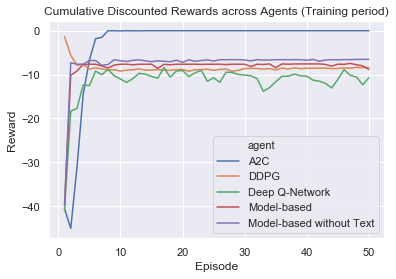

In [7]:
sns.lineplot('episode', 'discounted_reward', hue='agent',
             data=rewards_df.reset_index(['agent', 'episode'], drop=False))
plt.title('Cumulative Discounted Rewards across Agents (Training period)')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

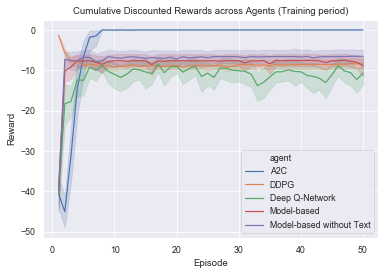

In [8]:
sns.set('paper')
sns.lineplot('episode', 'discounted_reward', hue='agent',
             data=training_history.groupby(['agent', 'ticker', 'episode'])
        .agg({'discounted_reward' : 'sum'}).reset_index(['agent', 'episode'], drop=False))
plt.title('Cumulative Discounted Rewards across Agents (Training period)')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.savefig('plots/rewards-all-agents.png')
plt.show()

In [95]:
test_history = pd.DataFrame()
with open("filtered_tickers.txt", "r") as src:
    filtered_tickers = src.read().split("\n")

agents = [DQN, A2C, DDPG, ModelBased_NoText_Agent, ModelBasedAgent]
# agents = [DQN, A2C, DDPG, ModelBasedAgent]
for A in agents:
    for i, ticker in tqdm(enumerate(filtered_tickers)):
        a = A()
        e_train = a.ENV_CONSTRUCTOR(ticker=ticker, mode='train')
        
        for i in range(1):
            h_train = a.run_episode(e_train)
#             h_train['mode'] = 'train'
#             h_train['t'] = range(len(h_train))
#             h_train['episode'] = int(i + 1)
#             h_train['agent'] = a.name
#             total_history = pd.concat([total_history, h_train])
        
        e_test = a.ENV_CONSTRUCTOR(ticker=ticker, mode='test')
        h_test = a.run_episode(e_test)
        h_test['t'] = range(len(h_train), len(h_test) + len(h_train))
        h_test['agent'] = a.name
        test_history = pd.concat([test_history, h_test])
        if i == 0:
            test_history.to_csv('test_history.csv', index=False)
        elif i % 10 == 0:
             test_history.to_csv('test_history.csv', mode='a', header=False, index=False)

386it [14:20,  2.23s/it]
386it [24:18,  3.78s/it]
386it [35:58,  5.59s/it]
386it [50:29,  7.85s/it]
386it [1:02:04,  9.65s/it]


In [112]:
test_history.ticker.unique()

array(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN',
       'ADBE', 'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES',
       'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL',
       'ALLE', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN',
       'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE',
       'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA',
       'BAC', 'BAX', 'BBY', 'BEN', 'BF-B', 'BIIB', 'BK', 'BKNG', 'BKR',
       'BLK', 'BLL', 'BMY', 'BR', 'BRK-B', 'BSX', 'BWA', 'BXP', 'C',
       'CAG', 'CAH', 'CAT', 'CB', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE',
       'CERN', 'CF', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX',
       'CMCSA', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COO',
       'COP', 'COST', 'COTY', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTL',
       'CTSH', 'CTXS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DHI',
       'DHR', 'DIS', 'DISCA', 'DISCK', 'DISH', 'DLTR', 'DOV', 'D

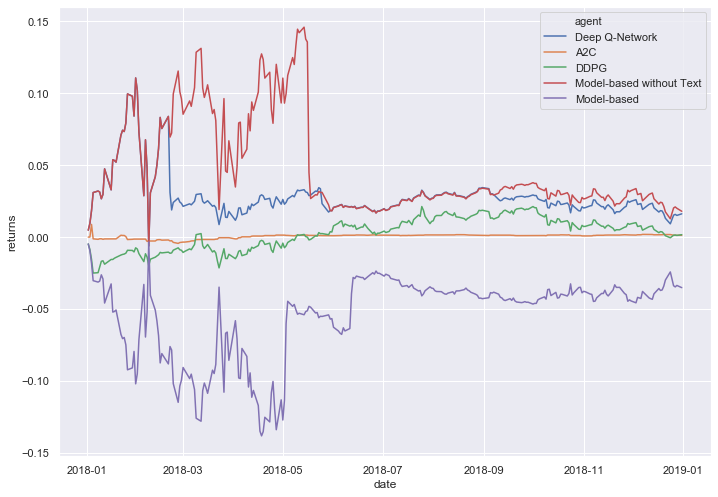

In [116]:
sns.lineplot('date', 'returns', data=test_history[test_history['ticker'] == 'MSFT'],
            hue='agent')

In [118]:
?sns.tsplot

Object `sns.tsplot` not found.


In [90]:
test_history = test_history.drop(['episode'], axis=1)

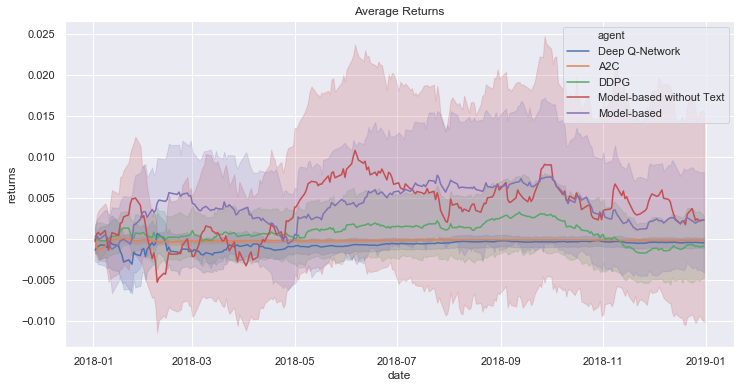

In [129]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 6)
plt.gcf().clear()
fig = plt.figure(1)

ax = sns.lineplot('date', 'returns', data=test_history, hue='agent', legend='brief',)
ax.set_title('Average Returns')
ax.grid('on')

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
# handles, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1.05, 1))
# fig.savefig('plots/average-returns-all.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
# fig.savefig('plots/average-returns-all.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('plots/average-returns-all.svg')
fig.savefig('plots/average-returns-all.png')

In [105]:
# sns.lineplot('date', 'returns', data=test_history, hue='agent', legend='brief')
# plt.title('Average Returns')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('plots/average-returns-all.svg')

In [18]:
test_history.columns

Index(['date', 'ticker', 'rewards', 'actions', 'returns', 'prices', 'mode',
       't', 'episode', 'agent'],
      dtype='object')

# Volatility in Test Set Performance

In [103]:
test_vol_history = test_history.groupby(['agent', 'ticker'])['returns'].rolling(14).std().reset_index()
test_vol_history
# test_history['vol_returns'] = test_history.groupby('agent')['returns'].rolling(14).std()
# test_history[['date', 'vol_returns', 'agent']]

,agent,ticker,Date,returns
0,A2C,A,2018-01-02,NaN
1,A2C,A,2018-01-03,NaN
2,A2C,A,2018-01-04,NaN
3,A2C,A,2018-01-05,NaN
4,A2C,A,2018-01-08,NaN
...,...,...,...,...
484425,Model-based without Text,ZTS,2018-12-24,0.035221
484426,Model-based without Text,ZTS,2018-12-26,0.034756
484427,Model-based without Text,ZTS,2018-12-27,0.033242
484428,Model-based without Text,ZTS,2018-12-28,0.032758


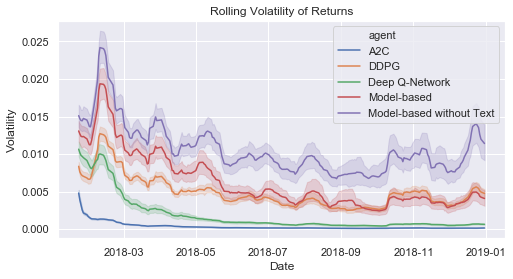

In [128]:
rcParams['figure.figsize'] = (8, 4)
sns.lineplot('Date', 'returns', data=test_vol_history, hue='agent', legend='brief')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Volatility')
plt.title('Rolling Volatility of Returns')
plt.savefig('plots/volatility-all.svg')
plt.savefig('plots/volatility-all.png')

In [121]:
def sharpe(y):
    return (y.mean() / (y.std() + 1e-6))

test_sharpe_history = test_history.groupby(['agent', 'ticker'])['returns'].rolling(14).apply(sharpe).reset_index()
test_sharpe_history[0:20]

,agent,ticker,Date,returns
0,A2C,A,2018-01-02,NaN
1,A2C,A,2018-01-03,NaN
2,A2C,A,2018-01-04,NaN
3,A2C,A,2018-01-05,NaN
4,A2C,A,2018-01-08,NaN
5,A2C,A,2018-01-09,NaN
6,A2C,A,2018-01-10,NaN
7,A2C,A,2018-01-11,NaN
8,A2C,A,2018-01-12,NaN
9,A2C,A,2018-01-16,NaN


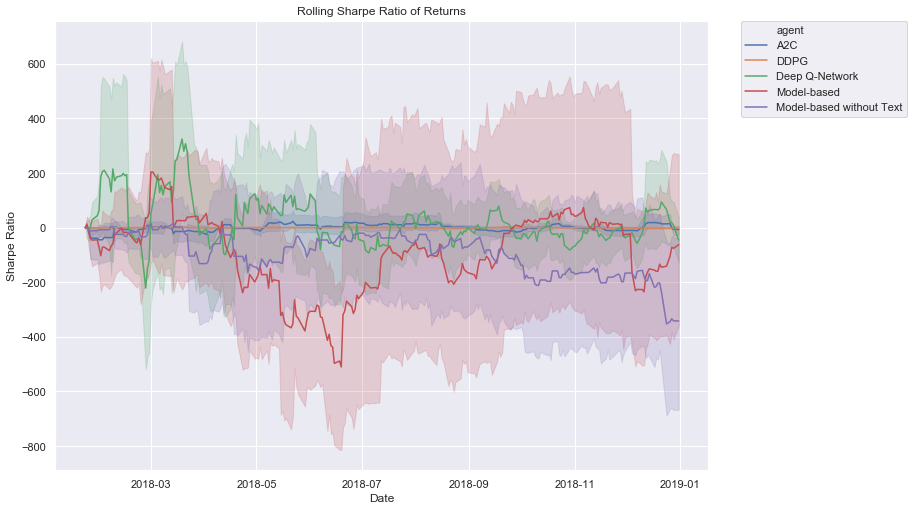

In [123]:
sns.lineplot('Date', 'returns', data=test_sharpe_history, hue='agent')
plt.ylabel('Sharpe Ratio')
plt.title('Rolling Sharpe Ratio of Returns')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.ylim((-20,20))
# plt.savefig('plots/sharpe-all.png')

In [69]:
not test_sharpe_history.agent.isin( ['A2C', 'Deep Q-Network'])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
q = sns.FacetGrid(data=h[h.episode % 5 == 0], row='ticker', hue='episode', aspect=6, legend_out=True)
q.map(sns.lineplot, 'date', 'returns')

In [ ]:
a2c_agent = A2C()

a2c_agent.train(num_tickers=1, episodes_per_ticker=1)

In [ ]:
h = a2c_agent.history
df = h
df['discounted_reward'] = df['t'].apply(lambda x : np.power(dqn_agent.gamma, x)) * df['rewards']
df.groupby(['ticker', 'episode']).agg({'discounted_reward' : 'sum'}).groupby('episode').agg({'discounted_reward' : 'mean'}).plot()

In [ ]:
h = a2c_agent.history
q = sns.FacetGrid(data=h[h.episode % 5 == 0], row='episode', aspect=6, legend_out=True)
q.map(sns.lineplot, 'date', 'returns')

In [ ]:
ddpg_agent = DDPG()
ddpg_agent.train(num_tickers=1, episodes_per_ticker=3)

In [ ]:
h = ddpg_agent.history
df = h
df['discounted_reward'] = df['t'].apply(lambda x : np.power(dqn_agent.gamma, x)) * df['rewards']
df.groupby(['ticker', 'episode']).agg({'discounted_reward' : 'sum'}).groupby('episode').agg({'discounted_reward' : 'mean'}).plot()

In [ ]:
h = ddpg_agent.history
q = sns.FacetGrid(data=h, row='episode', aspect=6)
q.map(sns.lineplot, 'date', 'returns')

In [ ]:
long_agent = LongOnlyAgent()
long_agent.train(num_tickers=1, episodes_per_ticker=3)

In [ ]:
h = long_agent.history
df = h
df['discounted_reward'] = df['t'].apply(lambda x : np.power(dqn_agent.gamma, x)) * df['rewards']
(df.groupby(['ticker', 'episode'])
     .agg({'discounted_reward' : 'sum'})
     .groupby('episode')
     .agg({'discounted_reward' : 'mean'})
     .plot())

In [ ]:
h = long_agent.history
q = sns.FacetGrid(data=h, row='episode', aspect=6)
q.map(sns.lineplot, 'date', 'returns')

In [ ]:
total_history = pd.DataFrame()
with open("filtered_tickers.txt", "r") as src:
    filtered_tickers = src.read().split("\n")


In [ ]:
for t in filtered_tickers:
    e_train = ModelBasedAgent.ENV_CONSTRUCTOR(t, mode='train')
    e_test  = ModelBasedAgent.ENV_CONSTRUCTOR(t, mode='test')
model_agent = ModelBasedAgent()
model_agent.train(num_tickers=1, episodes_per_ticker=)

In [ ]:
model_agent.history.head()

In [ ]:
df = model_agent.history
df['discounted_reward'] = df['t'].apply(lambda x : np.power(dqn_agent.gamma, x)) * df['rewards']

(df.groupby(['ticker', 'episode'])
     .agg({'discounted_reward' : 'sum'})
     .groupby('episode')
     .agg({'discounted_reward' : 'mean'})
     .plot(title=model_agent.name))

In [ ]:
h = model_agent.history
q = sns.FacetGrid(data=h, col='episode', row='ticker')
q.map(sns.lineplot, 't', 'returns')

In [ ]:
q = sns.FacetGrid(data=h, col='episode', row='ticker')
q.map(sns.lineplot, 't', 'rewards')

In [ ]:
sns.lineplot('t', 'prices', hue='ticker', data=h)